<a href="https://colab.research.google.com/github/jalammar/ecco/blob/main/notebooks/Language_Models_and_Ecco_PyData_Khobar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Intro to Ecco -- Making Language Models More Transparent
This notebook is an intro to [Ecco](https://www.eccox.io) and is the companion to the video: [Take A Look Inside Language Models With Ecco | PyData Khobar](https://www.youtube.com/watch?v=rHrItfNeuh0). 
 

In [1]:
# Install Ecco. This assumes you have pytorch installed.
###!pip install ecco
%pip install  --dry-run ecco
import warnings
#warnings.filterwarnings('ignore')

Note: you may need to restart the kernel to use updated packages.


In [2]:
import ecco

# Load pre-trained language model. Setting 'activations' to True tells Ecco to capture neuron activations.
# distillgpt is a distilled GPT2 model. You can also try 'gpt2' 
lm = ecco.from_pretrained('distilgpt2', activations=True)

## Overview

Complete the sentence:
`It was a matter of ____`

In [3]:
text = " it was a matter of"

# Generate one token
output_1 = lm.generate(text, generate=1, do_sample=False)

<IPython.core.display.Javascript object>

D:\conda\envs\pip310ecco\lib\site-packages\transformers\generation\utils.py:1255: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


<IPython.core.display.Javascript object>

In [4]:
output_1

<IPython.core.display.Javascript object>

In [5]:
# Show the top 10 candidate output tokens for position #5. 
# Layer 5 is the last layer in the model.
output_1.layer_predictions(position=5, layer=5, topk=10)

<IPython.core.display.Javascript object>

This view shows the top 10 candidate tokens, their probability, and their rankings.

### Comparing two token candidates for a single position

In [6]:
# What are the token IDs of the two words?
lm.tokenizer(" principle principal")

{'input_ids': [7989, 10033], 'attention_mask': [1, 1]}

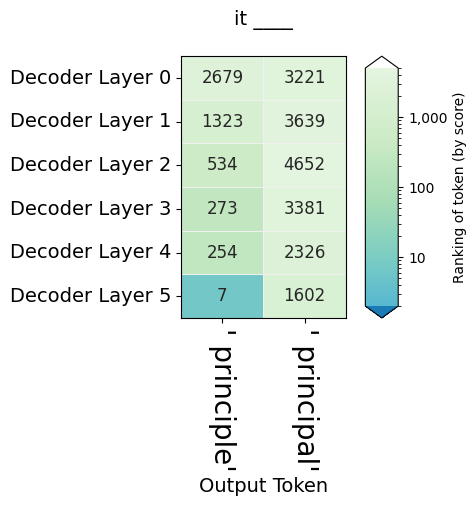

In [7]:
# Compare the rankings of "Principle" and "Principal" across layers
output_1.rankings_watch(watch=[7989, 10033], position=5)

## Exploring World Knowledge And Layer Analysis
Does the model "know" where Heathrow airport is located? To probe the model, we let's try the input sentence: 

`Heathrow airport is located in ____`

In [9]:
text = " Heathrow airport is located in"
output_2 = lm.generate(text, generate=5, do_sample=False)

<IPython.core.display.Javascript object>

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
output_2

<IPython.core.display.Javascript object>

While the output is not incorrect, it doesn't really anwer the question we are after. Let's slightly change the input sentence:

In [11]:
text = " Heathrow airport is located in the city of"
output_2 = lm.generate(text, generate=1, do_sample=False)

<IPython.core.display.Javascript object>

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


<IPython.core.display.Javascript object>

In [12]:
# What other tokens were possible to output in place of "London"?
output_2.layer_predictions(position=9, layer=5, topk=30)

<IPython.core.display.Javascript object>

D:\conda\envs\pip310ecco\lib\site-packages\ecco\output.py:469: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  token_id = torch.tensor(self.token_ids[0][offset + j])


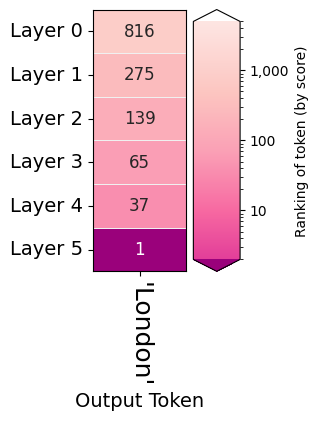

In [13]:
# Now that the model has selcted the tokens "London . \n"
# How did each layer rank these tokens during processing?
output_2.rankings()

This visualization is based on the great visual treatment by nostalgebraist in [Interpreting GPT: the logit lens](https://www.lesswrong.com/posts/AcKRB8wDpdaN6v6ru/interpreting-gpt-the-logit-lens).

### Probing the model's world knowledge 

What happens if we present the following input sentence to the model:

`The countries of the European Union are:\n1. Austria\n2. Belgium\n3. Bulgaria\n4. ___________`

Namely, we have these questions:
* Q. Will the model continue the numbering correctly?
* Q. Will it succeed in following the formatting?
* Q. Will it succeed in naming countries? European ones?
* Q. Will the model "notice" the alphabetical order of the list? Will it follow it?


In [14]:
text= "The countries of the European Union are:\n1. Austria\n2. Belgium\n3. Bulgaria\n4."

output_3 = lm.generate(text, generate=20, do_sample=True)

<IPython.core.display.Javascript object>

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The `rankings()` visualization view shows us at which layers the model resolved the output token for each position.

D:\conda\envs\pip310ecco\lib\site-packages\ecco\output.py:469: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  token_id = torch.tensor(self.token_ids[0][offset + j])


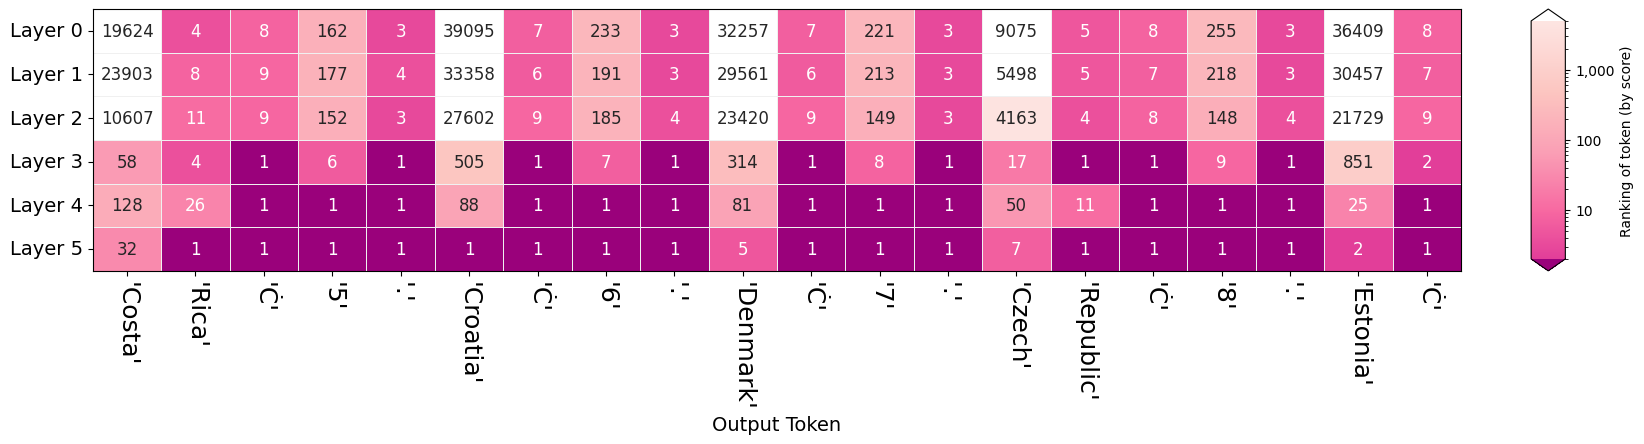

In [15]:
output_3.rankings()

The `saliency()` visualization shows which tokens contributed the most towards generating each output token (using the gradient X Input method):

In [16]:
output_3.saliency()

AttributeError: 'OutputSeq' object has no attribute 'saliency'

### Detailed saliency view
We can see a more detailed view of the saliency values using the detailed view:

In [17]:
output_3.saliency(style="detailed")

AttributeError: 'OutputSeq' object has no attribute 'saliency'

In [21]:

# Pass in `attribution` argument the list of primary attributions to be computed
# With ['ig', 'grad_x_input'] we are calculating Integrated Gradients and Input X Gradient saliency attributions
output = lm.generate(text, generate=20, do_sample=True, attribution=['ig', 'grad_x_input'])

<IPython.core.display.Javascript object>

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
https://github.com/jalammar/ecco/blob/main/notebooks/Ecco_Primary_Attributions.ipynb